In [1]:
from deepsudoku import REPO_PATH, DIFFICULTIES
import os
os.chdir(REPO_PATH)

import tensorflow as tf
import numpy as np
from deepsudoku.reinforcement_learning.ppo import *

import gymnasium as gym
from deepsudoku.verify_sudoku import *

2023-08-26 09:37:34.596182: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 09:37:34.625604: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-08-26 09:37:34.626419: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-08-26 09:37:35.249135: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Sudoku Environment avaible at gymnasium as 'Sudoku-v0'.


In [2]:
size = 3
sq_size = np.square(size)
sudoku_input_shape = (sq_size, sq_size)

In [3]:
# Create Multidiscrete models

# Implementation Detail 2: Orthogonal Initialization of hidden weights and constant initialization of biases and output weights
# Biases seem to be 0 by default in Keras
hidden_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=np.sqrt(2))
pol_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=0.01)
val_out_ortho_init = lambda: tf.keras.initializers.Orthogonal(gain=1)

def create_policy_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    x = tf.keras.layers.Dense(128, activation="tanh", kernel_initializer=hidden_ortho_init())(x)
    x = [tf.keras.layers.Dense(9, activation="linear", kernel_initializer=pol_out_ortho_init())(x) for i in range(3)]
    x = tf.keras.layers.Concatenate()(x)
    outputs = tf.keras.layers.Reshape((3,9))(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="pi")
    return model

def create_value_function_model():
    inputs = tf.keras.Input(shape=sudoku_input_shape)
    x = tf.keras.layers.Flatten()(inputs)
    x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    #x = tf.keras.layers.Dense(32, activation="relu", kernel_initializer=hidden_ortho_init())(x)
    outputs = tf.keras.layers.Dense(1, activation="linear", kernel_initializer=val_out_ortho_init())(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="V")
    return model


In [4]:
# create sudoku action mask
def action_mask(observation, logits):
    return logits

In [5]:
envs = PPO_MultiDiscrete_Environment_Wrapper('Sudoku-x0', 5, action_mask = action_mask, size=size)

In [7]:
pi, V = PPO(envs, create_policy_model(), create_value_function_model(), multi_discrete=True, TRAIN_EPOCHS = 1000, LEARNING_RATE_DECAY_PER_EPOCH = 0, LEARNING_RATE_START=0.001)

epoch:  0  ; KL:  0  ; LR:  0.001  ; MR:  0
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  1  ; KL:  379.1659  ; LR:  0.001  ; MR:  -0.992
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  2  ; KL:  100.40873  ; LR:  0.001  ; MR:  -0.984
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  3  ; KL:  17.354115  ; LR:  0.001  ; MR:  -0.98
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  4  ; KL:  1.7234691  ; LR:  0.001  ; MR:  -0.992
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  5  ; KL:  0.014402636  ; LR:  0.001  ; MR:  -0.98
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  6  ; KL:  0.3411615  ; LR:  0.001  ; MR:  -0.988
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  7  ; KL:  0.17880747  ; LR:  0.001  ; MR:  -0.976
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  8  ; KL:  0.018669391  ; LR:  0.001  ; MR:  -0.98
Collection
(5, 50, 3) (5, 50, 9, 9) (5, 50)
Tapework
epoch:  9  ; KL:  0.06

KeyboardInterrupt: 

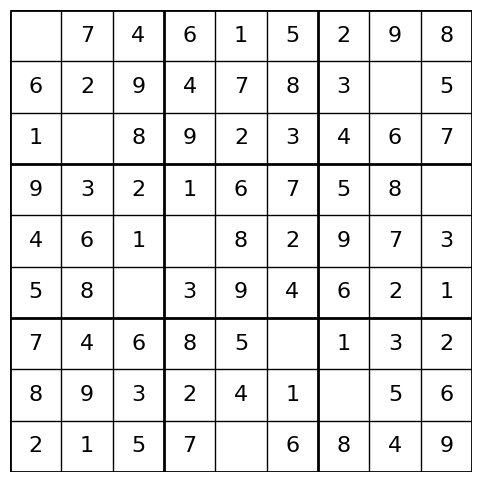

In [17]:

test_env = gym.make('Sudoku-x0', render_mode='human', size=size)
#test_env = gym.make('CartPole-v1', render_mode='human')
obs, inf = test_env.reset()
test_env.render()

tf.Tensor(
[[[-5.8649907  -3.6209269  -2.0680697  -7.3397145  -0.7801835
   -3.8999949  -1.3187032  -2.5704362  -3.8738463 ]
  [-2.986763   -7.0560184  -3.9652586  -0.42089784 -1.5404791
   -3.9418492  -3.9114628  -3.9757404  -7.131288  ]
  [-6.199985   -7.117755   -0.09967381 -3.9588506  -7.418715
   -4.3360496  -3.3514302  -4.3113933  -4.5277314 ]]], shape=(1, 3, 9), dtype=float32)
[4, 3, 2] False 0.5


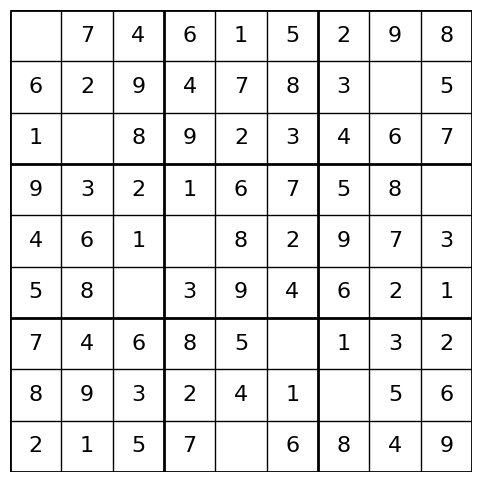

In [18]:
qs = pi(tf.expand_dims(obs, 0))
print(qs)
act = [np.argmax(subspace) for subspace in qs[0]]
obs, reward, terminated, _, _ = test_env.step(act)
print(act, terminated, reward)
test_env.render()